In [1]:
# 加载音频文件
from scipy.io import wavfile

def LoadWav(audio_file):
    sample_rate, signal = wavfile.read(audio_file)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))
    return sample_rate, signal

In [2]:
import numpy as np

# 获取 MAN 文件
def GenerateManSeq(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    slotCnt = int(slotCnt)
    manSeq = [0] * slotCnt
    stotal = (FRAME_RATE / BASE_RATE) * slotCnt

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second

        # round to an even number
        pos = round(stime / stotal * slotCnt)

        if 0 <= pos and pos < slotCnt:
            manSeq[pos] = HIGH_VALUE
    return np.array(manSeq)

# 获取 MAN 文件
def GenerateManSeqSec(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    lis = []

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second
        lis.append(stime)

    return lis

In [3]:
# 生成编号数列

def GetPreSeq(manSeq, length):
    preSeq = manSeq.copy()
    for i in range(1, len(preSeq)):
        preSeq[i] ^= preSeq[i - 1]
        
    assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))
    return preSeq[:length]

<ipython-input-3-a1912e3b4ef1>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))


In [4]:
import numpy as np
# np.set_printoptions(threshold=np.inf)

import pylab as pl
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
# download opensouce audio in
# http://www.voiptroubleshooter.com/open_speech/american.html
def mfcc(sample_rate, signal):
    # 一、预处理(Preprocess)
    # 加载模型(load audio)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))

    # signal = signal[: int(3.5 * sample_rate)]  # read first 3.5s data for example.

    # n_frames = len(signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, signal)
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Original audio')
    # pl.show()

    # 预加重(Pre-Emphasis)
    # y(t) = x(t) - a * x(t - 1)
    pre_emphasis = 0.97  # usually 0.95 or 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[: -1]
    )

    # n_frames = len(emphasized_signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, emphasized_signal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Pre-Emphasis')
    # pl.show()

    # 分帧(Framing)
    # here, params set as follows:
    # frame_size = 0.025(s), it menas 8kHz signal has 0.025 * 8000 = 200 samples.
    # frame_stride = 0.01(s), 0.01 * 8000 = 80 samples.
    # overlap = 0.015(s), 0.015 * 8000 = 125 samples.
    frame_size, frame_stride, overlap = 0.025, 0.01, 0.015  # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    singal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(
        float(np.abs(singal_length - frame_length)) / frame_step
    ))  # make sure we have at least 1 frame.

    pad_singal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_singal_length - singal_length))
    # pad singal to make sure that all frames have equal number of
    # samples without truncating any samples from the original signal.
    pad_singal = np.append(emphasized_signal, z)

    indices = np.tile(
        np.arange(0, frame_length), (num_frames, 1)
    ) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step),
        (frame_length, 1)
    ).T
    frames = pad_singal[indices.astype(np.int32, copy=False)]

    # 加窗(Window)
    # W(n, a) = (1 - a) - a * cos(2 * pi * n / (N - 1))
    # 0 <= n <= N, N is Window length, set a = 0.46 here.
    window = np.hamming(frame_length)
    # plt.plot(window)
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.title("Hamming window")
    # plt.show()

    # n = np.arange(0, frame_length)
    # window = 0.54 - 0.46 * np.cos(2.0 * np.pi * n) / (frame_length - 1)  # Explicit Implementation
    frames *= window

    # n_frames = len(pad_singal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, pad_singal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Framing')
    # pl.show()

    # 二、傅里叶变换(FFT)和功率谱(Power Spectrum)
    # do an N-pont FFT on each frame to calculate the frequency spectrum,
    # also called STFT(Short-time FT), where N is typically 256 or 512,
    NFFT = 512
    mag_frames = np.absolute((np.fft.rfft(frames, NFFT)))  # Magnitude of the FFT

    # compute the power spectrum using the following eqution:
    # P = |FFT(Xi)|^2 / N, Xi is ith frame of signal x.
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # 三、滤波器组(Filter Banks)
    # The final step to computing filter banks is applying triangular filters,
    # typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands.
    # convert frequency(f) and Mel(m) with equations:
    # m = 2595 * log10(1 + f / 700)
    # f = 700 * (10 ^ (m / 2595) - 1)
    n_filters = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # need 40 filters banks, so need 42 points
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # convert Mel to Hz
    # bin = sample_rate / NFFT  # fequency bin equation
    bins = np.floor((NFFT + 1) * hz_points / sample_rate)  # hz_points / bin

    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bins[m - 1])
        f_m = int(bins[m])
        f_m_plus = int(bins[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])

    # pl.plot(fbank.T)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("time()")
    # pl.title("40 Filter Banks")
    # pl.show()

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # db

    # pl.plot(filter_banks)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("Time")
    # pl.title("Spectrogram")
    # pl.show()

    # 四、梅尔频率倒谱系数(MFCCs)
    # apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients
    # and yield a compressed representation of the filter banks.
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 2: (num_ceps + 2)]  # keep 3-14

    # apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
    (n_frames, n_coeff) = mfcc.shape
    n = np.arange(n_coeff)
    cep_lifter = 22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [5]:
def GetSolveName(songid: str):
    assert len(songid) == 4
    return "./Data/SOLVE/%s.solve.json" % songid

In [6]:
class blank:
    def __init__(self):
        self.id = 0
        self.starttime = 0
        self.endtime = 0
        self.column = 0
        self.cut = 0

    def length(self):
        return self.endtime - self.starttime

    def print(self):
        print("id:%2d stime:%5d etime:%5d column:%d cut:%d" % (self.id, self.starttime, self.endtime, self.column, self.cut))

    def save(self, songid):
        BLANK_DATA_FILE = "./Data/JSON/BlankData.json"

        import json
        with open(BLANK_DATA_FILE) as fp:
            data = json.load(fp)

        data.append({
            'songid': songid,
            'id': self.id,
            'starttime': self.starttime,
            'endtime': self.endtime,
            'column': self.column,
            'cut': self.cut,
        })
        
        with open(BLANK_DATA_FILE, "w") as fp:
            json.dump(data, fp, indent=4)
    
    def saveToSolve(self, songid):
        SOLVE_FILE_NAME = GetSolveName(songid)

        import json
        with open(SOLVE_FILE_NAME) as fp:
            data = json.load(fp)

        data.append({ # 没有 songid
            'id': self.id,
            'starttime': self.starttime,
            'endtime': self.endtime,
            'column': self.column # 没有 cut
        })
        
        with open(SOLVE_FILE_NAME, "w") as fp:
            json.dump(data, fp, indent=4)



In [7]:
import pandas as pd

def GetMode(segment, K):
    cnt = [0] * K
    for i in range(len(segment)):
       cnt[segment[i]] += 1.0 / len(segment)
    return cnt

In [8]:
def GetKMeans(get_mfcc, K, WINDOW_LEN):
    from sklearn.preprocessing import StandardScaler
    data = get_mfcc.copy()

    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)

    from sklearn.cluster import KMeans
    kmeans = KMeans(K)
    kmeans.fit(data_scaled)
    mem = kmeans.labels_

    mem_reduce = [0] * len(mem)
    for i in range(len(mem_reduce)):
        mem_reduce[i] = GetMode(mem[max(i-WINDOW_LEN, 0) : min(i + WINDOW_LEN, len(mem_reduce))], K)
    mem_reduce = np.array(mem_reduce)

    return mem_reduce

In [9]:
def countblanks(unknownblank):
    cnt = 0
    blanks = []
    flags = [0, 0, 0, 0, 0, 0, 0, 0]
    isAblank = 0.6
    for i in range(unknownblank.shape[0]):
        for j in range(unknownblank.shape[1]):
            # print(i, j)
            if unknownblank[i][j] > isAblank and flags[j] == 0:
                cnt = cnt + 1
                flags[j] = cnt
                tmp = blank()
                tmp.id = cnt - 1
                tmp.starttime = i
                tmp.column = j
                blanks.append(tmp)
            elif unknownblank[i][j] > isAblank and flags[j] != 0:
                pass
            elif unknownblank[i][j] <= isAblank and flags[j] != 0:
                blanks[flags[j] - 1].endtime = i
                flags[j] = 0
            else: pass
    blanks[-1].endtime = unknownblank.shape[0]
    return blanks

def countpreblanks(preblank):
    cnt = 0
    blanks = []
    flags = 1
    isAblank = 0.6
    for i in range(preblank.shape[0]):
        if preblank[i] > isAblank and flags == 0:
            if cnt > 0:
                blanks[cnt - 1].endtime = i
            flags = 1
            tmp = blank()
            tmp.id = cnt
            tmp.starttime = i
            tmp.column = 8
            blanks.append(tmp)
            cnt = cnt + 1
        elif preblank[i] > isAblank and flags != 0:
            pass
        elif preblank[i] <= isAblank and flags != 0:
            if cnt > 0:
                blanks[cnt - 1].endtime = i
            flags = 0
            tmp = blank()
            tmp.id = cnt
            tmp.starttime = i
            tmp.column = 8
            blanks.append(tmp)
            cnt = cnt + 1
        else: pass
    blanks[-1].endtime = preblank.shape[0]
    return blanks

In [10]:
def judge(blanks, preblanks):
    MAXERROR = 400
    for blank in blanks:
        et = blank.endtime
        for pblank in preblanks:
            pet = pblank.endtime
            if pet >= et - MAXERROR and pet <= et + MAXERROR:
                blank.cut = 1
    return

In [11]:
def ShowMapForWav(wavFileName, manFileName, K = 16, WINDOW_LEN = 500, ALPHA = 0.3):
    music_id = wavFileName.split('/')[-1].split('.')[0]
    print("MUSIC_ID:", music_id)

    sample_rate, signal = LoadWav(wavFileName)
    get_mfcc = mfcc(sample_rate, signal)
    RATE = len(signal) / len(get_mfcc)

    # 总秒数 
    # totalTime = len(signal) // sample_rate

    manSeq = GenerateManSeq(len(signal) // RATE, manFileName, RATE, sample_rate, 1)
    
    get_pre = GetPreSeq(manSeq, len(get_mfcc))
    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, 3)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()
    plt.figure(figsize=(19, 5))

    print("SHAPE:", mem_blank.shape, len(get_pre))
    if mem_blank.shape[0] != len(get_pre):
        mem_blank = mem_blank[:len(get_pre),:]
        print("SHAPE:", mem_blank.shape, len(get_pre))
    print(mem_blank)
    # print(pd.Series(np.array(mem_blank).flatten()).value_counts())

    blanks = countblanks(mem_blank)
    preblanks = countpreblanks(get_pre)

    judge(blanks, preblanks)
    for b in blanks:
        b.print()
        b.save(music_id)
    
    import seaborn as sns
    sns.heatmap(np.c_[mem_blank, get_pre].T)

    # 要先保存再显示
    plt.savefig('./Data/NEWPIC/%s.png' % music_id)
    plt.show()
    return mem_blank

In [12]:
# 只保存数据不显示 man
def SaveDataIntoJson(wavFileName, K = 16, WINDOW_LEN = 500, ALPHA = 0.3):
    music_id = wavFileName.split('/')[-1].split('.')[0]

    sample_rate, signal = LoadWav(wavFileName)
    get_mfcc = mfcc(sample_rate, signal)
    RATE = len(signal) / len(get_mfcc)

    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, 3)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()

    blanks = countblanks(mem_blank)
    preblanks = []

    SOLVE_FILE_NAME = GetSolveName(music_id)

    # 清空文件内容
    import json
    json.dump([], open(SOLVE_FILE_NAME, "w"), indent=4)

    # judge(blanks, preblanks) # cut 最后都等于 0
    for b in blanks:
        b.print()
        b.saveToSolve(music_id)

In [13]:
# ShowMapForWav("./Data/WAV/0004.wav", "./Data/MAN/0004.man")

MUSIC_ID: 0032
sample_rate:44100, len:9527364
sample_rate:44100, len:9527364
SHAPE: (43206, 8) 43205
SHAPE: (43205, 8) 43205
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
id: 0 stime:    0 etime: 2123 column:4 cut:1
id: 1 stime: 2124 etime: 6942 column:2 cut:0
id: 2 stime: 6943 etime: 9278 column:1 cut:0
id: 3 stime: 9279 etime: 9283 column:7 cut:0
id: 4 stime: 9284 etime: 9287 column:1 cut:0
id: 5 stime: 9289 etime:10840 column:7 cut:0
id: 6 stime:10841 etime:13744 column:1 cut:1
id: 7 stime:13745 etime:13748 column:7 cut:1
id: 8 stime:13749 etime:14063 column:1 cut:1
id: 9 stime:14064 etime:14414 column:5 cut:0
id:10 stime:14415 etime:18148 column:0 cut:1
id:11 stime:18149 etime:18640 column:5 cut:0
id:12 stime:18641 etime:23090 column:3 cut:0
id:13 stime:23091 etime:24843 column:5 cut:1
id:14 stime:24844 etime:27023 column:7 cut:1
id:15 stime:27024 etime:29943 column:5 cut:0

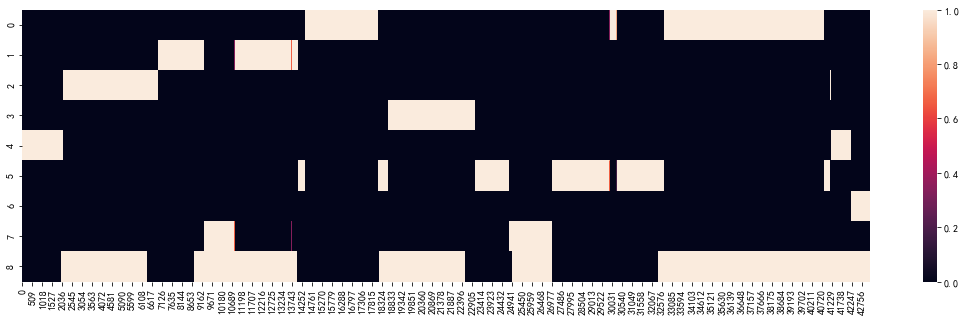

sample_rate:44100, len:9527364
sample_rate:44100, len:9527364
id: 0 stime:    0 etime: 2120 column:4 cut:0
id: 1 stime: 2121 etime: 6936 column:1 cut:0
id: 2 stime: 6937 etime: 7150 column:5 cut:0
id: 3 stime: 7151 etime: 7201 column:2 cut:0
id: 4 stime: 7202 etime: 7448 column:5 cut:0
id: 5 stime: 7449 etime: 9382 column:2 cut:0
id: 6 stime: 9383 etime: 9411 column:5 cut:0
id: 7 stime: 9412 etime: 9437 column:2 cut:0
id: 8 stime: 9438 etime:10941 column:5 cut:0
id: 9 stime:10942 etime:11087 column:2 cut:0
id:10 stime:11088 etime:11116 column:5 cut:0
id:11 stime:11117 etime:13529 column:2 cut:0
id:12 stime:13530 etime:14040 column:5 cut:0
id:13 stime:14041 etime:14420 column:3 cut:0
id:14 stime:14421 etime:18153 column:0 cut:0
id:15 stime:18154 etime:18634 column:3 cut:0
id:16 stime:18635 etime:23097 column:7 cut:0
id:17 stime:23098 etime:24836 column:3 cut:0
id:18 stime:24837 etime:27032 column:5 cut:0
id:19 stime:27033 etime:29971 column:3 cut:0
id:20 stime:29972 etime:30178 column:0

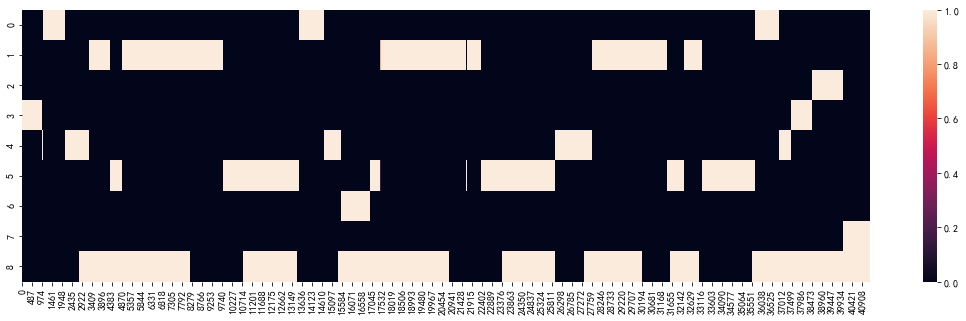

sample_rate:44100, len:9112418
sample_rate:44100, len:9112418
id: 0 stime:    0 etime:  979 column:1 cut:0
id: 1 stime:  980 etime: 1029 column:2 cut:0
id: 2 stime: 1030 etime: 2127 column:7 cut:0
id: 3 stime: 2128 etime: 3268 column:2 cut:0
id: 4 stime: 3269 etime: 4304 column:0 cut:0
id: 5 stime: 4305 etime: 4893 column:5 cut:0
id: 6 stime: 4894 etime: 9815 column:0 cut:0
id: 7 stime: 9816 etime:13364 column:5 cut:0
id: 8 stime:13365 etime:14710 column:7 cut:0
id: 9 stime:14711 etime:15557 column:2 cut:0
id:10 stime:15558 etime:16961 column:6 cut:0
id:11 stime:16962 etime:17476 column:5 cut:0
id:12 stime:17477 etime:22395 column:0 cut:0
id:13 stime:22396 etime:25955 column:5 cut:0
id:14 stime:25956 etime:27776 column:2 cut:0
id:15 stime:27777 etime:31418 column:0 cut:0
id:16 stime:31419 etime:32266 column:5 cut:0
id:17 stime:32267 etime:33130 column:0 cut:0
id:18 stime:33131 etime:35704 column:5 cut:0
id:19 stime:35705 etime:36884 column:7 cut:0
id:20 stime:36885 etime:37492 column:2

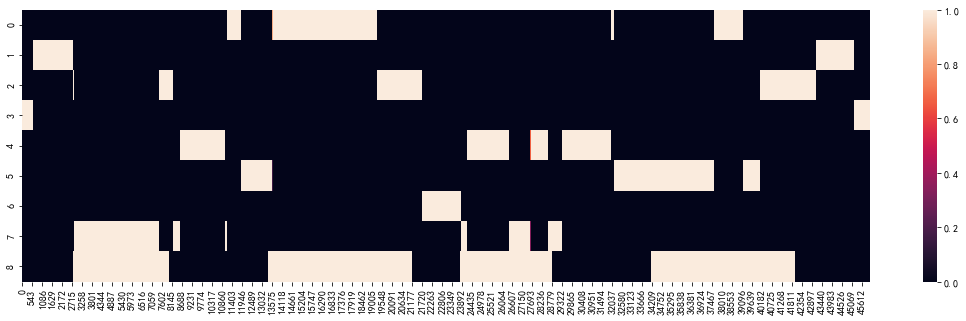

sample_rate:44100, len:10162176
sample_rate:44100, len:10162176
id: 0 stime:    0 etime:  538 column:5 cut:0
id: 1 stime:  539 etime: 2782 column:4 cut:0
id: 2 stime: 2783 etime: 2852 column:1 cut:0
id: 3 stime: 2853 etime: 7436 column:0 cut:0
id: 4 stime: 7437 etime: 8228 column:1 cut:0
id: 5 stime: 8229 etime: 8596 column:0 cut:0
id: 6 stime: 8597 etime:11047 column:6 cut:0
id: 7 stime:11048 etime:11185 column:0 cut:0
id: 8 stime:11186 etime:19281 column:2 cut:0
id: 9 stime:19282 etime:21731 column:1 cut:0
id:10 stime:21732 etime:23889 column:3 cut:0
id:11 stime:23890 etime:24185 column:0 cut:0
id:12 stime:24186 etime:26443 column:6 cut:0
id:13 stime:26444 etime:27682 column:0 cut:0
id:14 stime:27683 etime:28576 column:6 cut:0
id:15 stime:28577 etime:29350 column:0 cut:0
id:16 stime:29351 etime:32030 column:6 cut:0
id:17 stime:32031 etime:40119 column:2 cut:0
id:18 stime:40120 etime:43094 column:1 cut:0
id:19 stime:43095 etime:44652 column:7 cut:0
id:20 stime:44653 etime:45276 column

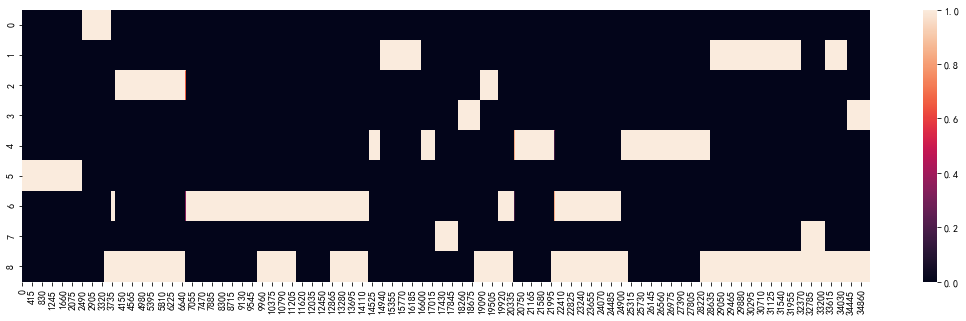

sample_rate:44100, len:7772591
sample_rate:44100, len:7772591
id: 0 stime:    0 etime: 2443 column:4 cut:0
id: 1 stime: 2444 etime: 3735 column:2 cut:0
id: 2 stime: 3736 etime: 3843 column:1 cut:0
id: 3 stime: 3844 etime: 6802 column:0 cut:0
id: 4 stime: 6803 etime:14178 column:1 cut:0
id: 5 stime:14179 etime:14913 column:6 cut:0
id: 6 stime:14914 etime:16874 column:7 cut:0
id: 7 stime:16875 etime:17166 column:6 cut:0
id: 8 stime:17167 etime:18990 column:5 cut:0
id: 9 stime:18991 etime:19790 column:0 cut:0
id:10 stime:19791 etime:20333 column:1 cut:0
id:11 stime:20334 etime:21173 column:6 cut:0
id:12 stime:21174 etime:22237 column:3 cut:0
id:13 stime:22238 etime:24804 column:1 cut:0
id:14 stime:24805 etime:28577 column:6 cut:0
id:15 stime:28578 etime:32408 column:7 cut:0
id:16 stime:32409 etime:33427 column:5 cut:0
id:17 stime:33428 etime:33462 column:7 cut:0
id:18 stime:33463 etime:34843 column:3 cut:0
id:19 stime:34844 etime:35248 column:4 cut:0
MUSIC_ID: 0036
sample_rate:44100, len:

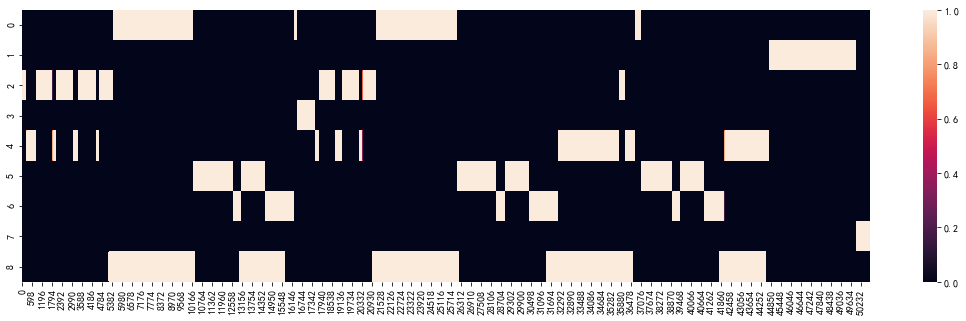

sample_rate:44100, len:11204608
sample_rate:44100, len:11204608
id: 0 stime:    0 etime:  821 column:0 cut:0
id: 1 stime:  822 etime: 1809 column:2 cut:0
id: 2 stime: 1810 etime: 2071 column:0 cut:0
id: 3 stime: 2072 etime: 3044 column:2 cut:0
id: 4 stime: 3045 etime: 3367 column:0 cut:0
id: 5 stime: 3368 etime: 4448 column:2 cut:0
id: 6 stime: 4449 etime: 4614 column:0 cut:0
id: 7 stime: 4615 etime: 4619 column:2 cut:0
id: 8 stime: 4620 etime: 4628 column:0 cut:0
id: 9 stime: 4629 etime: 5475 column:2 cut:0
id:10 stime: 5476 etime:10243 column:6 cut:0
id:11 stime:10244 etime:12441 column:7 cut:0
id:12 stime:12442 etime:13353 column:1 cut:0
id:13 stime:13354 etime:14278 column:7 cut:0
id:14 stime:14279 etime:15050 column:1 cut:0
id:15 stime:15051 etime:16296 column:3 cut:0
id:16 stime:16297 etime:16485 column:6 cut:0
id:17 stime:16486 etime:17764 column:0 cut:0
id:18 stime:17765 etime:18820 column:2 cut:0
id:19 stime:18821 etime:19144 column:0 cut:0
id:20 stime:19145 etime:20188 column

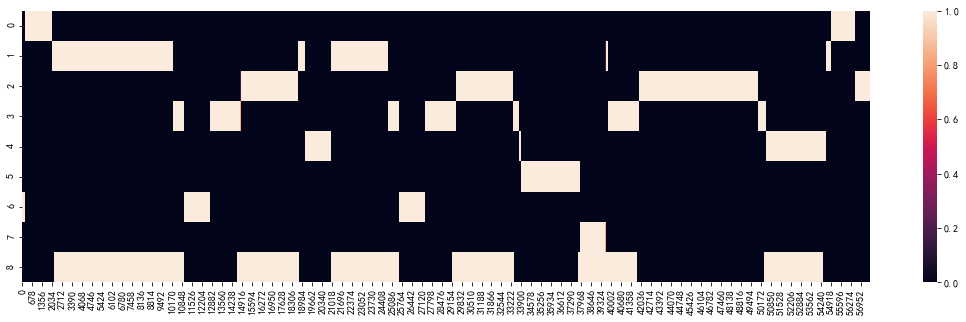

sample_rate:48000, len:13822895
sample_rate:48000, len:13822895
id: 0 stime:    0 etime:  656 column:7 cut:0
id: 1 stime:  657 etime: 1917 column:6 cut:0
id: 2 stime: 1918 etime: 2232 column:7 cut:0
id: 3 stime: 2233 etime: 2742 column:5 cut:0
id: 4 stime: 2743 etime: 6006 column:2 cut:0
id: 5 stime: 6007 etime:10299 column:5 cut:0
id: 6 stime:10300 etime:10970 column:0 cut:0
id: 7 stime:10971 etime:11936 column:2 cut:0
id: 8 stime:11937 etime:12826 column:7 cut:0
id: 9 stime:12827 etime:14801 column:4 cut:0
id:10 stime:14802 etime:14817 column:0 cut:0
id:11 stime:14818 etime:18681 column:3 cut:0
id:12 stime:18682 etime:19482 column:5 cut:0
id:13 stime:19483 etime:20854 column:1 cut:0
id:14 stime:20855 etime:25042 column:5 cut:0
id:15 stime:25043 etime:25552 column:4 cut:0
id:16 stime:25553 etime:25569 column:5 cut:0
id:17 stime:25570 etime:26549 column:2 cut:0
id:18 stime:26550 etime:27361 column:7 cut:0
id:19 stime:27362 etime:29235 column:4 cut:0
id:20 stime:29236 etime:29533 column

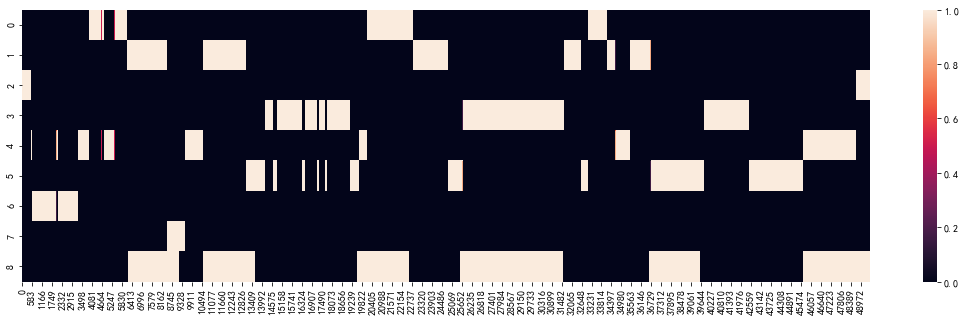

sample_rate:44100, len:10917504
sample_rate:44100, len:10917504
id: 0 stime:    0 etime:   73 column:7 cut:0
id: 1 stime:   74 etime: 3252 column:3 cut:0
id: 2 stime: 3253 etime: 3928 column:6 cut:0
id: 3 stime: 3929 etime: 4654 column:0 cut:0
id: 4 stime: 4655 etime: 4679 column:6 cut:0
id: 5 stime: 4680 etime: 4790 column:0 cut:0
id: 6 stime: 4791 etime: 5418 column:6 cut:0
id: 7 stime: 5419 etime: 6146 column:0 cut:0
id: 8 stime: 6147 etime: 8464 column:4 cut:0
id: 9 stime: 8465 etime: 9510 column:5 cut:0
id:10 stime: 9511 etime:10593 column:6 cut:0
id:11 stime:10594 etime:13038 column:4 cut:0
id:12 stime:13039 etime:14389 column:1 cut:0
id:13 stime:14390 etime:14403 column:2 cut:0
id:14 stime:14404 etime:14480 column:1 cut:0
id:15 stime:14481 etime:14488 column:2 cut:0
id:16 stime:14489 etime:14952 column:1 cut:0
id:17 stime:14953 etime:16080 column:2 cut:0
id:18 stime:16081 etime:16777 column:1 cut:0
id:19 stime:16778 etime:16812 column:2 cut:0
id:20 stime:16813 etime:17035 column

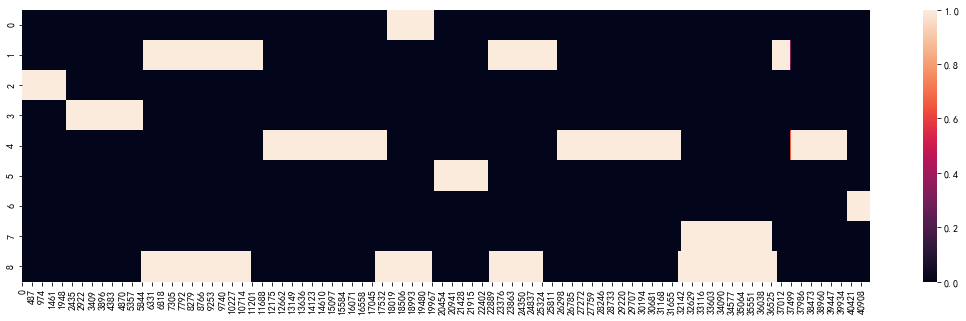

sample_rate:44100, len:9116928
sample_rate:44100, len:9116928
id: 0 stime:    0 etime: 5862 column:1 cut:0
id: 1 stime: 5863 etime: 5940 column:5 cut:0
id: 2 stime: 5941 etime:11814 column:0 cut:0
id: 3 stime:11815 etime:16362 column:5 cut:0
id: 4 stime:16363 etime:17819 column:2 cut:0
id: 5 stime:17820 etime:20050 column:7 cut:0
id: 6 stime:20051 etime:22769 column:3 cut:0
id: 7 stime:22770 etime:26063 column:0 cut:0
id: 8 stime:26064 etime:30262 column:5 cut:0
id: 9 stime:30263 etime:30514 column:2 cut:0
id:10 stime:30515 etime:30529 column:5 cut:0
id:11 stime:30530 etime:32191 column:2 cut:0
id:12 stime:32192 etime:36659 column:4 cut:0
id:13 stime:36660 etime:36896 column:2 cut:0
id:14 stime:36897 etime:37182 column:0 cut:0
id:15 stime:37183 etime:37230 column:2 cut:0
id:16 stime:37231 etime:37470 column:0 cut:0
id:17 stime:37471 etime:39434 column:5 cut:0
id:18 stime:39435 etime:40269 column:2 cut:0
id:19 stime:40270 etime:41345 column:6 cut:0


In [15]:
N = 39
for i in range(32, N + 1):
    name = "%04d" % i
    manFileName = "./Data/MAN/%s.man" % name
    wavFileName = "./Data/WAV/%s.wav" % name

    import os
    if os.path.exists(manFileName):
        ShowMapForWav(wavFileName, manFileName)

    # 无论如何都会制作这个
    SaveDataIntoJson(wavFileName)
